# Full Pipeline: From Your Own MT Images to Automated Segmentation

**No ground truth annotations needed!**

This notebook demonstrates how to apply the SynthMT approach to **your own microtubule images**. If you have read [our paper](https://DATEXIS.github.io/SynthMT-project-page) and want to see how far you can get with our approach on your own data, this is the place to start.

## What You Need
- **Only unlabeled MT images** (IRM or TIRF microscopy)
- No manual annotations required!

## What You'll Get
1. **Synthetic training data** tuned to match your real images
2. **Optimized SAM3Text model** adapted to your specific domain
3. **Quantitative comparison** showing the improvement from HPO

## Pipeline Overview

![Full Pipeline Overview](images/data_gen_overview.png)

*The optimization loop iteratively refines parameters θ by maximizing cosine similarity between real and synthetic embeddings in DINOv2 space.*


In [1]:
import json
import os
import shutil
from functools import partial
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import matplotlib.pyplot as plt
import numpy as np
import optuna

from examples.utils import create_overlay, get_preprocess_params
from synth_mt.benchmark.dataset import BenchmarkDataset
from synth_mt.benchmark.metrics import calculate_segmentation_metrics, calculate_downstream_metrics
from synth_mt.benchmark.models.factory import setup_model_factory
from synth_mt.config.tuning import TuningConfig
from synth_mt.data_generation.optimization.embeddings import ImageEmbeddingExtractor
from synth_mt.data_generation.optimization.eval import evaluate_tuning_cfg
from synth_mt.data_generation.optimization.metrics import precompute_matric_args
from synth_mt.data_generation.optimization.objective import objective
from synth_mt.model_hpo.model_hpo import objective_function
from synth_mt.utils import postprocessing as post
from synth_mt.utils import preprocessing as pre

%matplotlib inline

Logging to .logs/2026-01-12T15:21:07.log


---
# Step 1: Point to Your Own MT Images

**This is the only input you need to provide!**

Simply set `YOUR_IMAGES_DIR` to a folder containing your MT microscopy images. These images:
- Do NOT need ground truth annotations
- Should be IRM or TIRF microscopy images of microtubules
- Can be PNG, JPG, or TIFF format

In [2]:
# ============================================================
# 👉 CONFIGURE THIS: Point to your own MT images
# ============================================================
YOUR_IMAGES_DIR = "example_images"  # Change this to your image folder

dataset_real = BenchmarkDataset(
    YOUR_IMAGES_DIR,
    num_samples=3, # -1 for all images
)

print(f"Found {len(dataset_real)} images in '{YOUR_IMAGES_DIR}':")
n_display = min(5, len(dataset_real))
for idx in range(n_display):
    print(f"  - {dataset_real.get_image_path(idx)}")
if len(dataset_real) > n_display:
    print(f"  ... and {len(dataset_real) - 5} more")

2026-01-12 15:21:07,206 - WARNING - synth_mt.benchmark.dataset - Dataset does not contain masks: example_images


Found 3 images in 'example_images':
  - example_images/image_0.png
  - example_images/image_1.png
  - example_images/image_2.png


## 1.1 Visualize Your Input Images

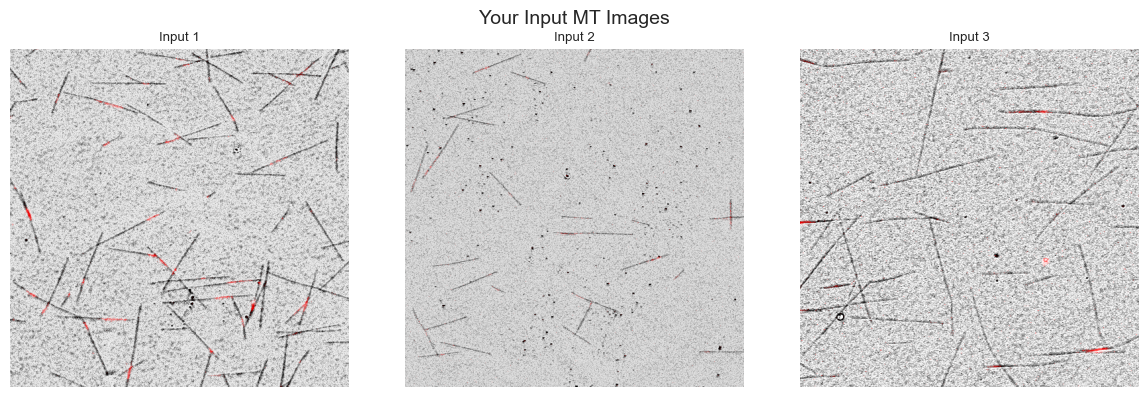

In [3]:
# Display a few of your input images
fig, axs = plt.subplots(1, n_display, figsize=(4 * n_display, 4))
if n_display == 1:
    axs = [axs]

for idx, (ax, sample) in enumerate(zip(axs, dataset_real)):
    img = sample[0]
    ax.imshow(img)
    ax.set_title(f"Input {idx+1}")
    ax.axis("off")

plt.suptitle("Your Input MT Images", fontsize=14)
plt.tight_layout()
plt.show()

---
# Step 2: Tune Synthetic Data to Match Your Images

The optimization aligns synthetic image distributions with your real images:
- Your images are embedded using **DINOv2** (pre-trained vision transformer)
- Synthetic images are generated and also embedded
- Parameters θ are optimized to **maximize cosine similarity**

In [4]:
# Load tuning configuration (or create a custom one)
cfg_path = "tuning_config_example.json"
tuning_cfg = TuningConfig.load(cfg_path)

# Override with your image directory
tuning_cfg.reference_images_dir = YOUR_IMAGES_DIR
tuning_cfg.validate()

print(f"Reference images: {tuning_cfg.reference_images_dir}")
print(f"Optimization trials: {tuning_cfg.num_trials}")

Reference images: example_images
Optimization trials: 20


In [5]:
# Compute embeddings from YOUR images
embedding_extractor = ImageEmbeddingExtractor(tuning_cfg)
ref_embeddings = embedding_extractor.extract_from_references()
precomputed_kwargs = precompute_matric_args(tuning_cfg, ref_embeddings)

print(f"Extracted {ref_embeddings.shape[0]} embeddings from your images")

2026-01-12 15:21:07,679 - INFO - httpx - HTTP Request: HEAD https://huggingface.co/facebook/dinov2-large/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-01-12 15:21:07,684 - INFO - httpx - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/facebook/dinov2-large/47b73eefe95e8d44ec3623f8890bd894b6ea2d6c/config.json "HTTP/1.1 200 OK"


Loading weights:   0%|          | 0/439 [00:00<?, ?it/s]

2026-01-12 15:21:08,114 - INFO - httpx - HTTP Request: HEAD https://huggingface.co/facebook/dinov2-large/resolve/main/processor_config.json "HTTP/1.1 404 Not Found"
2026-01-12 15:21:08,236 - INFO - httpx - HTTP Request: HEAD https://huggingface.co/facebook/dinov2-large/resolve/main/preprocessor_config.json "HTTP/1.1 307 Temporary Redirect"
2026-01-12 15:21:08,242 - INFO - httpx - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/facebook/dinov2-large/47b73eefe95e8d44ec3623f8890bd894b6ea2d6c/preprocessor_config.json "HTTP/1.1 200 OK"
2026-01-12 15:21:08,365 - INFO - httpx - HTTP Request: HEAD https://huggingface.co/facebook/dinov2-large/resolve/main/processor_config.json "HTTP/1.1 404 Not Found"
2026-01-12 15:21:08,485 - INFO - httpx - HTTP Request: HEAD https://huggingface.co/facebook/dinov2-large/resolve/main/preprocessor_config.json "HTTP/1.1 307 Temporary Redirect"
2026-01-12 15:21:08,491 - INFO - httpx - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/m

Extracted 3 embeddings from your images


In [6]:
# Setup Optuna study
db_filename = f"{tuning_cfg.output_config_id}.db"
db_filepath = os.path.join(tuning_cfg.temp_dir, db_filename)
os.makedirs(tuning_cfg.temp_dir, exist_ok=True)
storage_uri = f"sqlite:///{db_filepath}"

study_synth = optuna.create_study(
    sampler=optuna.samplers.TPESampler(),
    study_name=f"{tuning_cfg.output_config_id}",
    storage=storage_uri,
    direction=tuning_cfg.direction,
    load_if_exists=True,
)

objective_fcn = partial(
    objective,
    tuning_cfg=tuning_cfg,
    ref_embeddings=ref_embeddings,
    embedding_extractor=embedding_extractor,
    **precomputed_kwargs,
)

[I 2026-01-12 15:21:09,819] Using an existing study with name 'example' instead of creating a new one.


In [7]:
# Run optimization
N_TRIALS_SYNTH = 25  # Increase for better results (100 recommended)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study_synth.optimize(objective_fcn, n_trials=N_TRIALS_SYNTH)

print(f"\n✓ Optimization complete!")
print(f"  Best similarity score: {study_synth.best_value:.4f}")


✓ Optimization complete!
  Best similarity score: 0.9062


/var/folders/52/8qxbs16x11x9ymms7mxc2kqm0000gn/T/ipykernel_60209/514928828.py:2: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_optimization_history(study_synth)


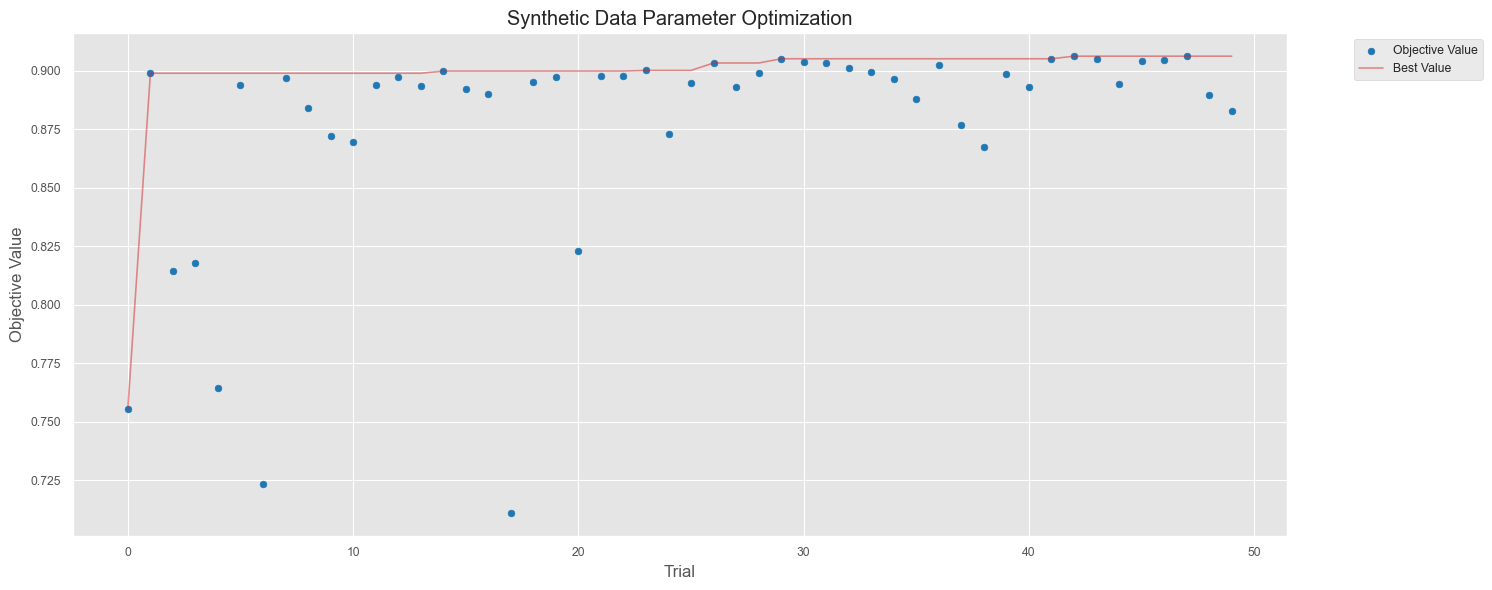

In [8]:
# Visualize optimization progress
ax = optuna.visualization.matplotlib.plot_optimization_history(study_synth)
fig = ax.figure
fig.set_size_inches(15, 6)
plt.title("Synthetic Data Parameter Optimization")
plt.tight_layout()
plt.show()

---
# Step 3: Generate Synthetic Training Data

Using the optimized parameters, we generate synthetic images with **automatic ground-truth masks**.

In [9]:
# Generate synthetic samples with the best configuration
best_trial = study_synth.best_trial

NUM_SYNTHETIC_SAMPLES = 5 # increase for better results (we used 10 in the paper)

synthetic_data_dir = "synthetic_data_output"

if os.path.exists(synthetic_data_dir):

    # ask user if they want to overwrite existing output directory
    overwrite_response = input(f"Output directory '{synthetic_data_dir}' already exists. Overwrite? (y/n) ")
    if overwrite_response.lower() != "y":
        print("Exiting...")
        exit(1)

    print(f"Removing existing output directory: {synthetic_data_dir}")
    shutil.rmtree(synthetic_data_dir)

modified_tuning_cfg_path = "tuning_config_modified.json"
tuning_cfg.output_config_num_best = NUM_SYNTHETIC_SAMPLES
tuning_cfg.output_config_num_frames = 1
tuning_cfg.save(modified_tuning_cfg_path)

print(f"Generating {NUM_SYNTHETIC_SAMPLES} synthetic samples...")
tuning_cfg.num_trials = NUM_SYNTHETIC_SAMPLES
evaluate_tuning_cfg(
    tuning_config_path=modified_tuning_cfg_path,
    output_dir=synthetic_data_dir,
)

print(f"✓ Generated frames with ground-truth masks")

2026-01-12 15:21:26,154 - INFO - synth_mt.data_generation.optimization.eval - Trial 1/5: Value = 0.9062


Generating 5 synthetic samples...


Series example_rank_1 frames: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]
2026-01-12 15:21:26,639 - INFO - synth_mt.data_generation.optimization.eval - Trial 2/5: Value = 0.9061
Series example_rank_2 frames: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]
2026-01-12 15:21:27,046 - INFO - synth_mt.data_generation.optimization.eval - Trial 3/5: Value = 0.9051
Series example_rank_3 frames: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
2026-01-12 15:21:27,478 - INFO - synth_mt.data_generation.optimization.eval - Trial 4/5: Value = 0.9050
Series example_rank_4 frames: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]
2026-01-12 15:21:27,887 - INFO - synth_mt.data_generation.optimization.eval - Trial 5/5: Value = 0.9048
Series example_rank_5 frames: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

✓ Generated frames with ground-truth masks


---
# Step 4: Compare SAM3Text With and Without HPO

Now comes the key experiment: we compare SAM3Text performance:
1. **Default parameters** (zero-shot)
2. **Optimized parameters** (few-shot via synthetic data HPO)

We evaluate on both **synthetic data** (where we have ground truth) and **your real images** (visual comparison).


## 4.1 Prepare Data for Evaluation

In [10]:
# Load synthetic dataset for evaluation
dataset_synthetic = BenchmarkDataset(
    os.path.join("synthetic_data_output", "small", "images"),
    num_samples=NUM_SYNTHETIC_SAMPLES,
    mask_mapping=("images", "image_masks"),
)

print(f"Found: {len(dataset_synthetic)} synthetic + {len(dataset_real)} real images for evaluation")

Found: 5 synthetic + 3 real images for evaluation


## 4.2 Setup Models: Default vs Optimized

In [11]:
factory = setup_model_factory()
MODEL_NAME = "sam3text"

# Create DEFAULT model (zero-shot)
default_model = factory.create_model(MODEL_NAME)
default_model.load_model()
print("✓ Loaded SAM3Text with DEFAULT parameters")

2026-01-12 15:21:28,373 - WARNING - synth_mt.benchmark.models.fiesta - Matlab engine not available
2026-01-12 15:21:28,411 - WARNING - root - Failed to import micro_sam: No module named 'micro_sam'
2026-01-12 15:21:28,412 - WARNING - root - Failed to import stardist: No module named 'stardist'
2026-01-12 15:21:28,566 - INFO - httpx - HTTP Request: HEAD https://huggingface.co/facebook/sam3/resolve/main/config.json "HTTP/1.1 200 OK"
2026-01-12 15:21:28,688 - INFO - httpx - HTTP Request: HEAD https://huggingface.co/facebook/sam3/resolve/main/model.safetensors "HTTP/1.1 302 Found"


Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

2026-01-12 15:21:32,504 - INFO - httpx - HTTP Request: HEAD https://huggingface.co/facebook/sam3/resolve/main/preprocessor_config.json "HTTP/1.1 404 Not Found"
2026-01-12 15:21:32,631 - INFO - httpx - HTTP Request: HEAD https://huggingface.co/facebook/sam3/resolve/main/config.json "HTTP/1.1 200 OK"
2026-01-12 15:21:32,774 - INFO - httpx - HTTP Request: HEAD https://huggingface.co/facebook/sam3/resolve/main/tokenizer_config.json "HTTP/1.1 200 OK"
2026-01-12 15:21:32,900 - INFO - httpx - HTTP Request: GET https://huggingface.co/api/models/facebook/sam3/tree/main/additional_chat_templates?recursive=false&expand=false "HTTP/1.1 404 Not Found"
2026-01-12 15:21:33,024 - INFO - ht

✓ Loaded SAM3Text with DEFAULT parameters


In [24]:
# Setup HPO for the optimized model
METRIC = "IoU"
USE_SKELETON = True
N_TRIALS_HPO = 10  # Increase for better results

direction = "maximize" if METRIC == "IoU" else "minimize"

# Get postprocessing ranges - these values are depending on you data
postprocessing_props = {
    "min_area": 10,
    "max_area": 10000,
    "min_length": 5,
    "max_length": 256,
}

TEMP_DIR = tuning_cfg.temp_dir
MODEL_DIR = os.path.join(tuning_cfg.temp_dir, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

In [25]:
# Run HPO
hpo_db_path = os.path.join(TEMP_DIR, f"{MODEL_NAME}_hpo.db")
hpo_storage_uri = f"sqlite:///{hpo_db_path}"

study_hpo = optuna.create_study(
    study_name=f"{MODEL_NAME}_hpo",
    storage=hpo_storage_uri,
    direction=direction,
    load_if_exists=True,
)

print(f"Running HPO on synthetic data ({N_TRIALS_HPO} trials)...")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_hpo.optimize(
    lambda trial: objective_function(
        trial, factory, MODEL_NAME, dataset_synthetic,
        postprocessing_props, METRIC, TEMP_DIR, MODEL_DIR, USE_SKELETON,
    ),
    n_trials=N_TRIALS_HPO,
)

print(f"\n✓ HPO complete! Best {METRIC}: {study_hpo.best_value:.4f}")

Running HPO on synthetic data (10 trials)...

✓ HPO complete! Best IoU: 0.9628


/var/folders/52/8qxbs16x11x9ymms7mxc2kqm0000gn/T/ipykernel_60209/3326805177.py:2: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_optimization_history(study_hpo)


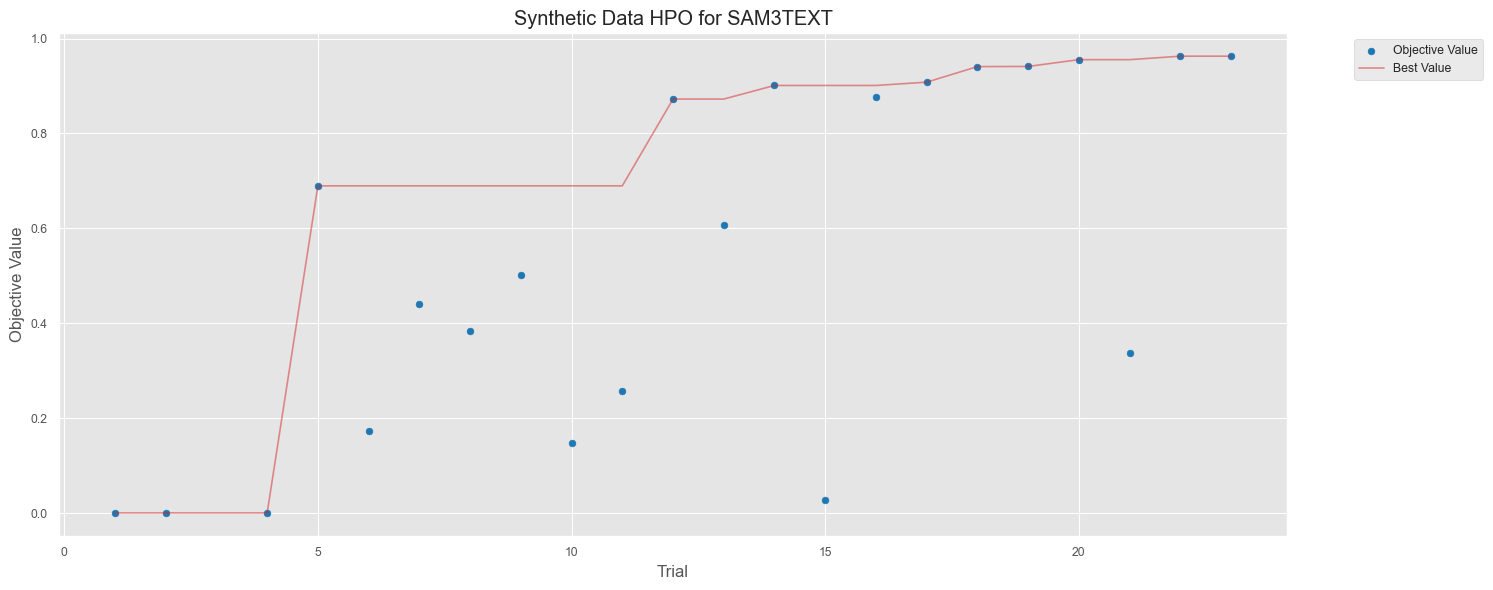

In [26]:
# Visualize optimization progress
ax = optuna.visualization.matplotlib.plot_optimization_history(study_hpo)
fig = ax.figure
fig.set_size_inches(15, 6)
plt.title(f"Synthetic Data HPO for {MODEL_NAME.upper()}")
plt.tight_layout()
plt.show()

In [27]:
# Create OPTIMIZED model
best_params = study_hpo.best_params.copy()
best_params["save_dir"] = MODEL_DIR
best_params["work_dir"] = TEMP_DIR

optimized_model = factory.create_model(MODEL_NAME, **best_params)
optimized_model.load_model()
print("✓ Loaded SAM3Text with OPTIMIZED parameters")

print("\nParameter comparison:")
print(f"{'Parameter':<30} {'Default':>15} {'Optimized':>15}")
print("-" * 60)
for key in best_params:
    default_val = getattr(default_model, key, "N/A")
    opt_val = best_params[key]
    if isinstance(default_val, float):
        print(f"{key:<30} {default_val:>15.2f} {opt_val:>15.2f}")
    else:
        print(f"{key:<30} {str(default_val):>15} {str(opt_val):>15}")


✓ Loaded SAM3Text with OPTIMIZED parameters

Parameter comparison:
Parameter                              Default       Optimized
------------------------------------------------------------
percentile_min                            0.00            0.99
percentile_max                          100.00           95.57
sharpen_radius                            0.00            1.55
smooth_radius                             0.00            4.26
rescale_using_percentiles                False            True
invert                                   False           False
histogram_normalization                  False            True
clip_to_percentiles                      False           False
threshold                                 0.50            0.45
mask_threshold                            0.50            0.14
text_prompt_option                           0               8
grayscale                                False            True
save_dir                                   N/A    .te

## 4.3 Evaluate on Synthetic Data (with Ground Truth)

In [28]:
def run_predictions(model, dataset):
    """Run predictions with a model on a dataset."""
    preprocess_params = get_preprocess_params(model)

    all_gt_masks = []
    all_pred_masks = []
    all_images = []

    for idx in range(len(dataset)):
        image, gt_masks, _ = dataset[idx]
        processed_image = pre.process_image(image, **preprocess_params)
        pred_mask = model.predict(processed_image)

        if pred_mask is not None:
            all_images.append(image)
            all_gt_masks.append(gt_masks)
            all_pred_masks.append(pred_mask)

    return all_images, all_gt_masks, all_pred_masks

# Run both models on synthetic data
print("Running DEFAULT model on synthetic data...")
_, gt_masks_synth, pred_default_synth = run_predictions(default_model, dataset_synthetic)

print("Running OPTIMIZED model on synthetic data...")
images_synth, _, pred_optimized_synth = run_predictions(optimized_model, dataset_synthetic)

Running DEFAULT model on synthetic data...
Running OPTIMIZED model on synthetic data...


In [29]:
# Calculate metrics for both models on synthetic data
metrics_default, _ = calculate_segmentation_metrics(
    gt_masks=gt_masks_synth,
    pred_masks=pred_default_synth,
    use_skeletonized_version=True,
)

metrics_optimized, _ = calculate_segmentation_metrics(
    gt_masks=gt_masks_synth,
    pred_masks=pred_optimized_synth,
    use_skeletonized_version=True,
)

downstream_default = calculate_downstream_metrics(
    gt_masks=gt_masks_synth,
    pred_masks=pred_default_synth,
    pixel_per_micrometer=9.0,
)

downstream_optimized = calculate_downstream_metrics(
    gt_masks=gt_masks_synth,
    pred_masks=pred_optimized_synth,
    pixel_per_micrometer=9.0,
)

In [30]:
# Print comparison table
print("\n" + "=" * 70)
print("COMPARISON: SAM3Text DEFAULT vs OPTIMIZED on SYNTHETIC DATA")
print("=" * 70)

print(f"\n{'SEGMENTATION METRICS':<35} {'Default':>15} {'Optimized':>15}")
print("-" * 70)
for key in ["SKIoU_mean", "F1@0.50", "F1@0.75"]:
    if key in metrics_default and key in metrics_optimized:
        improvement = metrics_optimized[key] - metrics_default[key]
        arrow = "↑" if improvement > 0 else "↓" if improvement < 0 else "→"
        print(f"{key:<35} {metrics_default[key]:>15.4f} {metrics_optimized[key]:>15.4f} {arrow}")

print(f"\n{'DOWNSTREAM METRICS':<35} {'Default':>15} {'Optimized':>15}")
print("-" * 70)
for key in ["Count Abs Err", "Length Avg Abs Err (um)", "Length_KL", "Curvature Avg Abs Err (1/um)", "Curvature_KL"]:
    if key in downstream_default and key in downstream_optimized:
        # Lower is better for these metrics
        improvement = downstream_optimized[key] - downstream_default[key]
        arrow = "↑" if improvement > 0 else "↓" if improvement < 0 else "="
        print(f"{key:<35} {downstream_default[key]:>15.4f} {downstream_optimized[key]:>15.4f} {arrow}")


COMPARISON: SAM3Text DEFAULT vs OPTIMIZED on SYNTHETIC DATA

SEGMENTATION METRICS                        Default       Optimized
----------------------------------------------------------------------
SKIoU_mean                                   0.9392          0.9628 ↑
F1@0.50                                      0.9751          0.9892 ↑
F1@0.75                                      0.9751          0.9892 ↑

DOWNSTREAM METRICS                          Default       Optimized
----------------------------------------------------------------------
Count Abs Err                                1.0000          0.4000 ↓
Length Avg Abs Err (um)                      0.1012          0.4148 ↑
Length_KL                                    0.5730          0.3930 ↓
Curvature Avg Abs Err (1/um)                 1.1793          1.1962 ↑
Curvature_KL                                 0.0950          0.2480 ↑


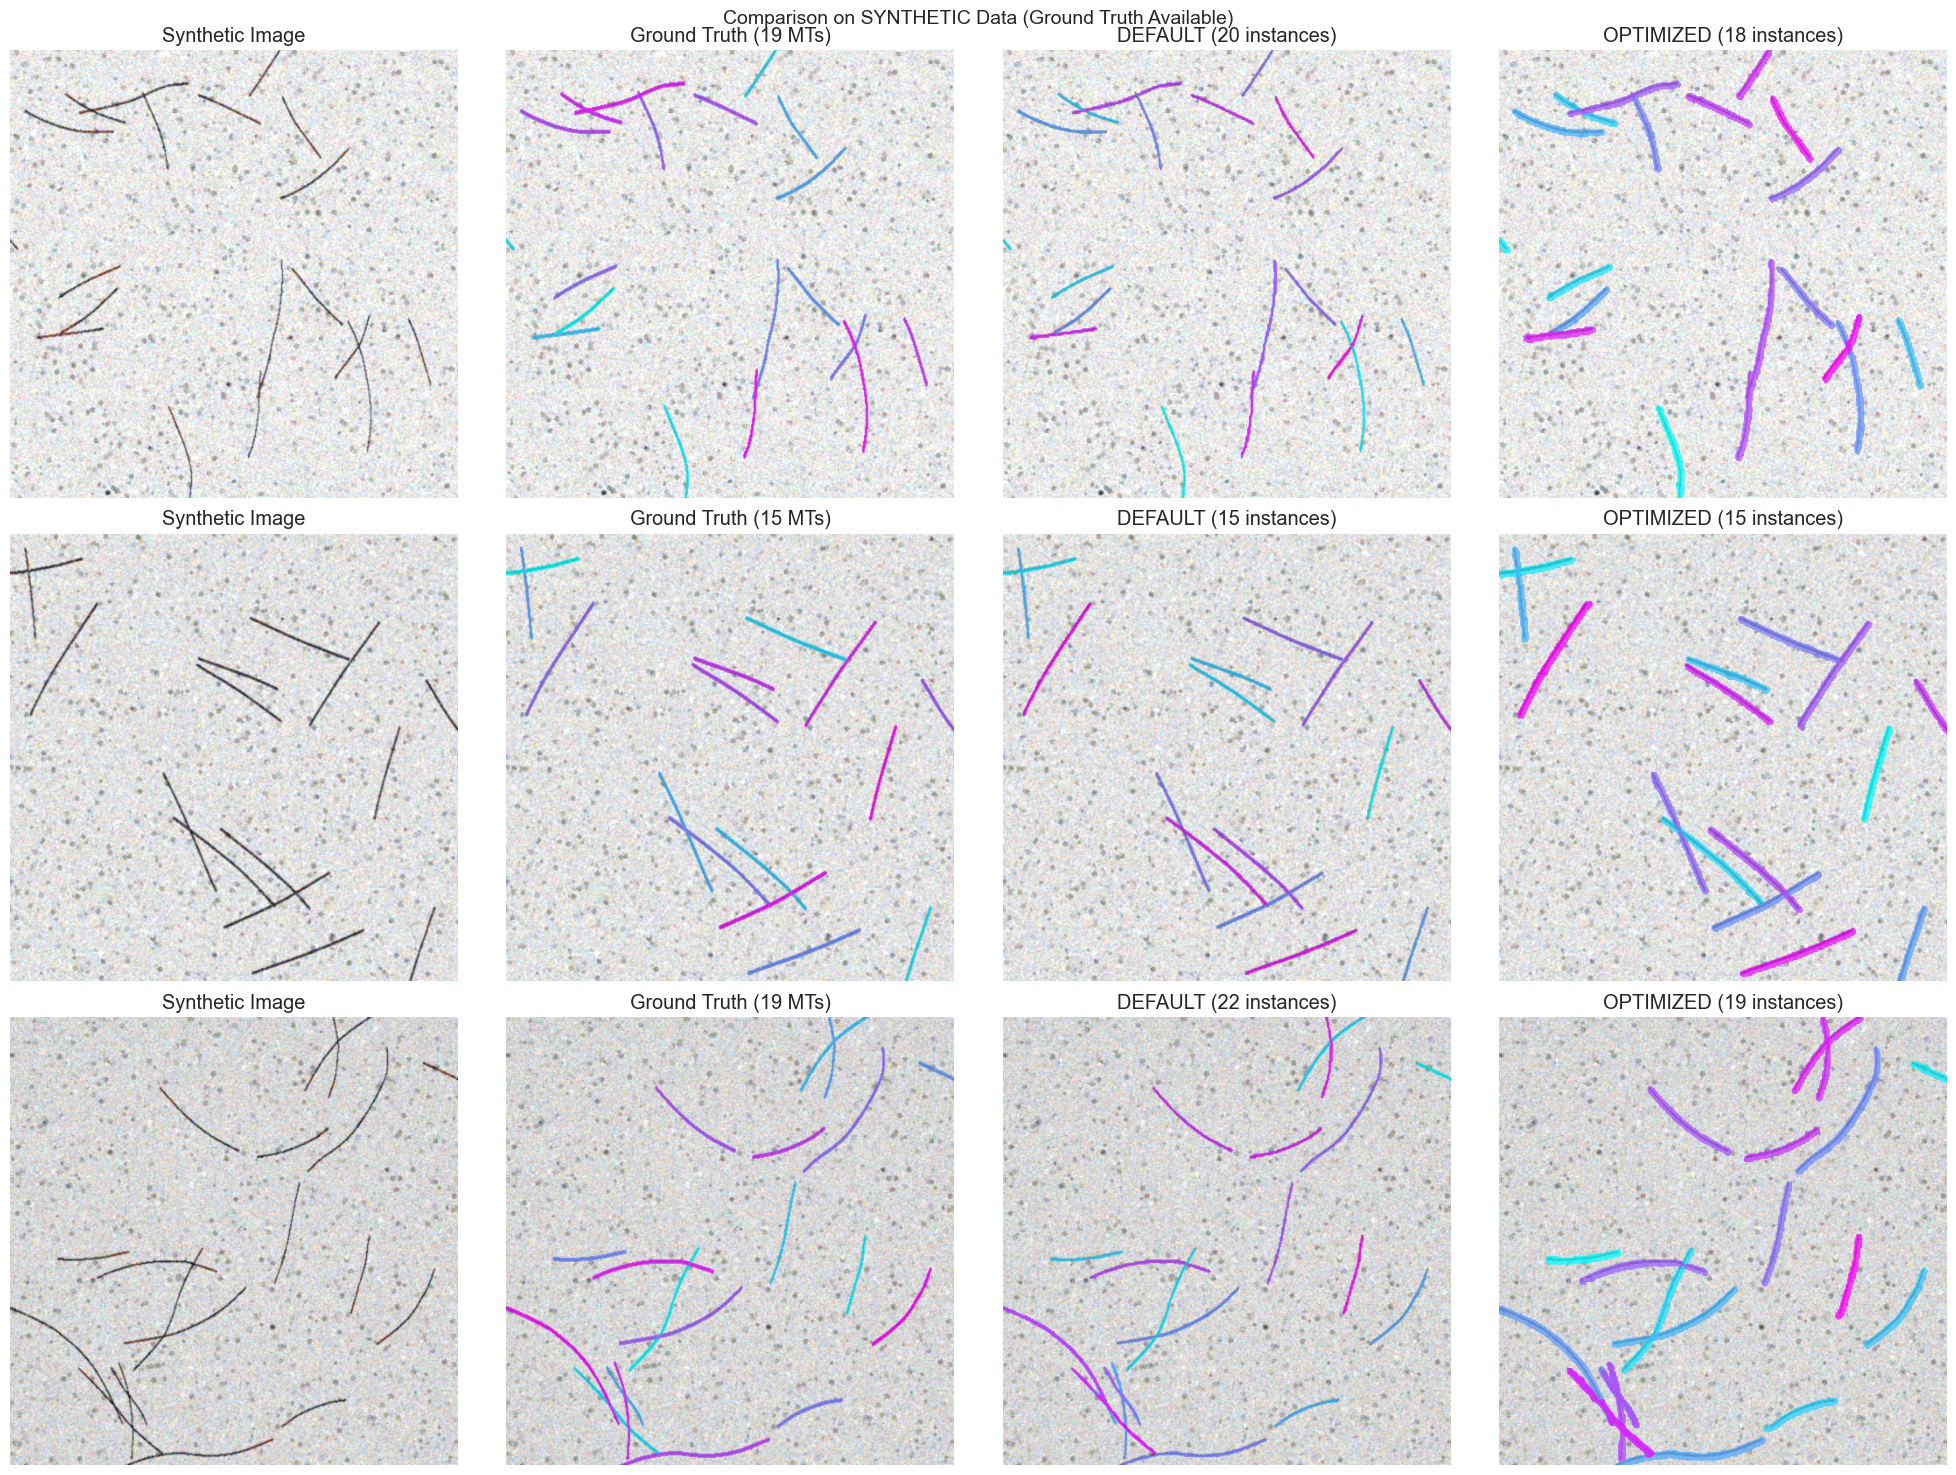

In [31]:
# Visual comparison on synthetic data
n_show = min(3, len(images_synth))
fig, axs = plt.subplots(n_show, 4, figsize=(20, 5 * n_show))

for idx in range(n_show):
    axs[idx, 0].imshow(images_synth[idx])
    axs[idx, 0].set_title("Synthetic Image")

    axs[idx, 1].imshow(create_overlay(images_synth[idx], gt_masks_synth[idx]))
    axs[idx, 1].set_title(f"Ground Truth ({gt_masks_synth[idx].shape[0]} MTs)")

    axs[idx, 2].imshow(create_overlay(images_synth[idx], pred_default_synth[idx]))
    n_pred_def = len(np.unique(pred_default_synth[idx])) - 1
    axs[idx, 2].set_title(f"DEFAULT ({n_pred_def} instances)")

    axs[idx, 3].imshow(create_overlay(images_synth[idx], pred_optimized_synth[idx]))
    n_pred_opt = len(np.unique(pred_optimized_synth[idx])) - 1
    axs[idx, 3].set_title(f"OPTIMIZED ({n_pred_opt} instances)")

    for ax in axs[idx]:
        ax.axis("off")

plt.suptitle("Comparison on SYNTHETIC Data (Ground Truth Available)", fontsize=14)
plt.tight_layout()
plt.show()

## 4.4 Evaluate on Your Real Images (Visual Comparison)

Since we don't have ground truth for your real images, we show visual comparison of segmentation quality.

In [32]:
def run_on_real_images(model, images):
    """Run predictions on real images."""
    preprocess_params = get_preprocess_params(model)
    predictions = []

    for sample in images:
        image, _, _ = sample
        processed = pre.process_image(image, **preprocess_params)
        pred = model.predict(processed)
        predictions.append(pred)

    return predictions

print("Running DEFAULT model on your real images...")
pred_default_real = run_on_real_images(default_model, dataset_real)

print("Running OPTIMIZED model on your real images...")
pred_optimized_real = run_on_real_images(optimized_model, dataset_real)

Running DEFAULT model on your real images...
Running OPTIMIZED model on your real images...


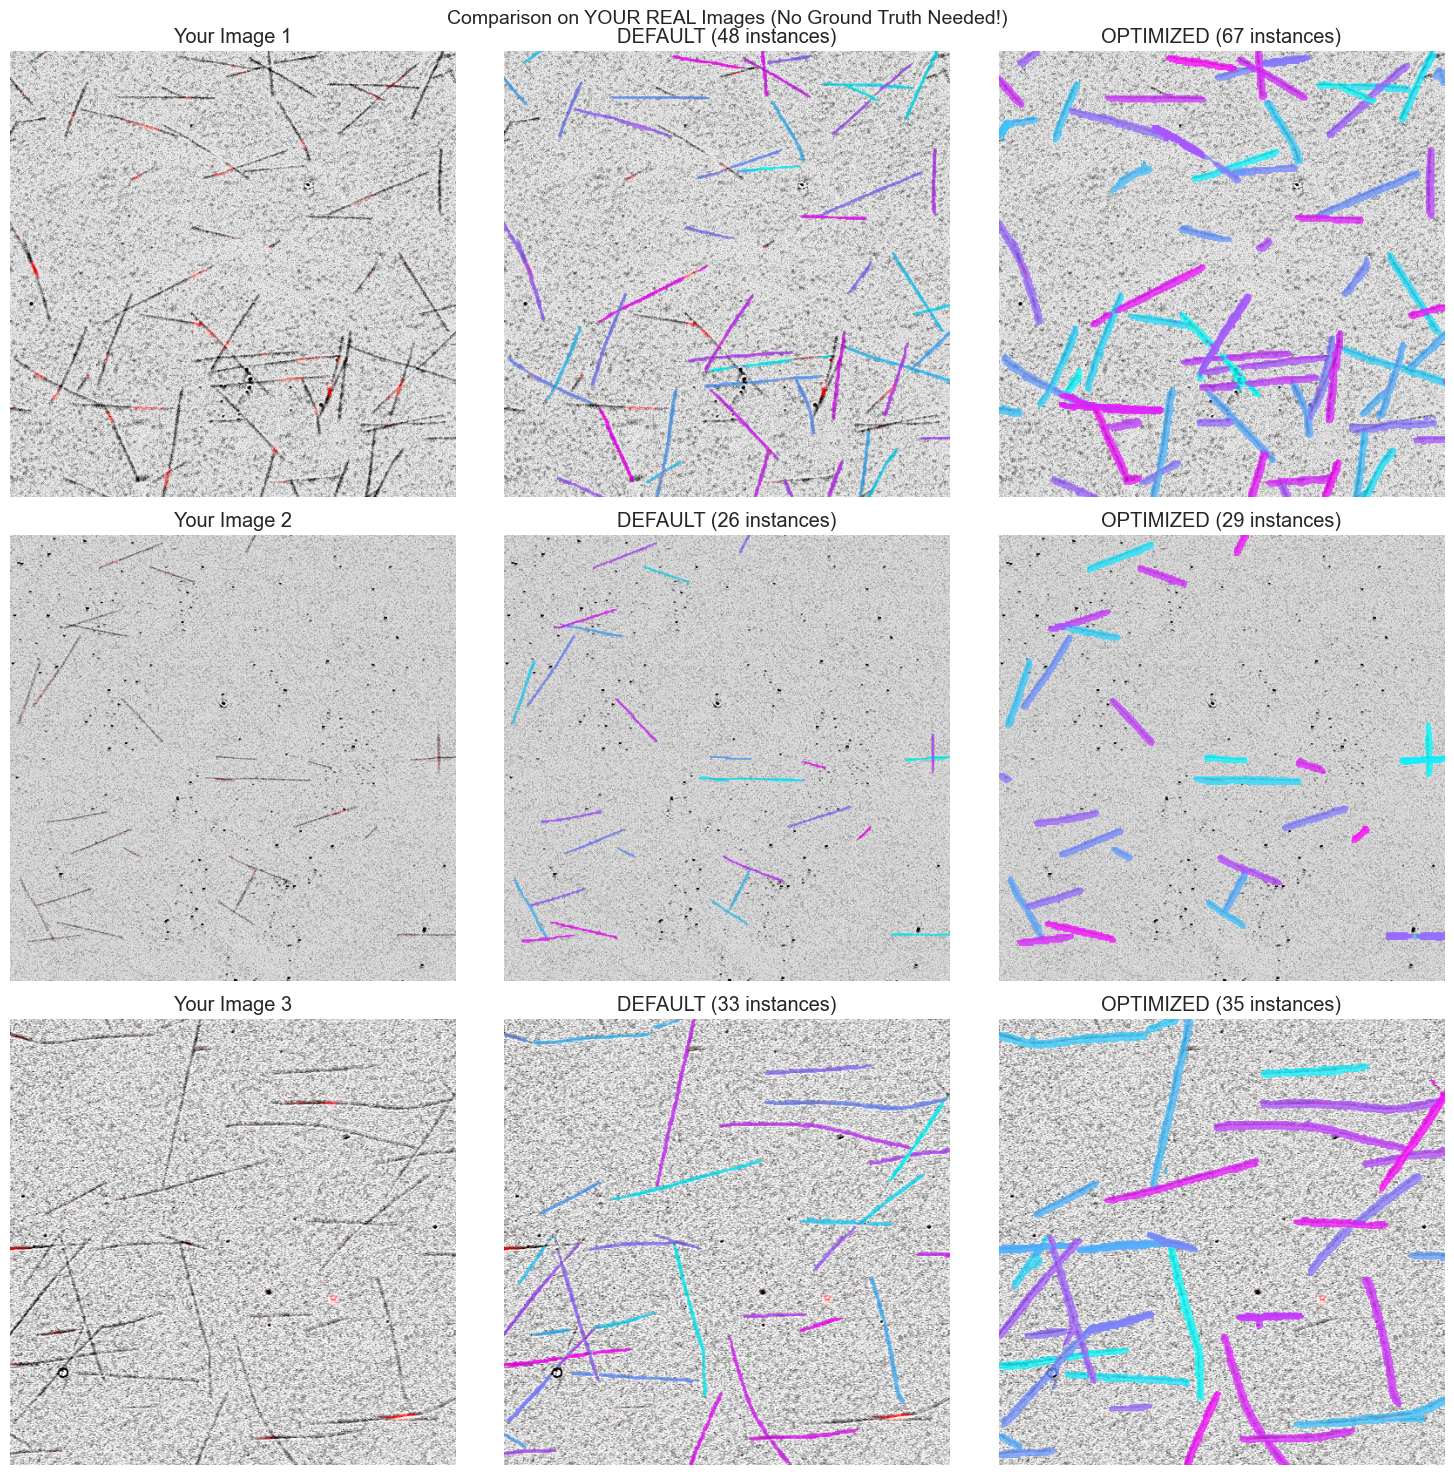

In [33]:
# Visual comparison on real images
n_show = min(len(dataset_real), 5)
fig, axs = plt.subplots(n_show, 3, figsize=(15, 5 * n_show))
if n_show == 1:
    axs = axs.reshape(1, -1)

for idx in range(n_show):
    image = dataset_real[idx][0]
    axs[idx, 0].imshow(image)
    axs[idx, 0].set_title(f"Your Image {idx+1}")

    if pred_default_real[idx] is not None:
        axs[idx, 1].imshow(create_overlay(image, pred_default_real[idx]))
        n_def = len(np.unique(pred_default_real[idx])) - 1
        axs[idx, 1].set_title(f"DEFAULT ({n_def} instances)")
    else:
        axs[idx, 1].imshow(image)
        axs[idx, 1].set_title("DEFAULT (no prediction)")

    if pred_optimized_real[idx] is not None:
        axs[idx, 2].imshow(create_overlay(image, pred_optimized_real[idx]))
        n_opt = len(np.unique(pred_optimized_real[idx])) - 1
        axs[idx, 2].set_title(f"OPTIMIZED ({n_opt} instances)")
    else:
        axs[idx, 2].imshow(image)
        axs[idx, 2].set_title("OPTIMIZED (no prediction)")

    for ax in axs[idx]:
        ax.axis("off")

plt.suptitle("Comparison on YOUR REAL Images (No Ground Truth Needed!)", fontsize=14)
plt.tight_layout()
plt.show()

---
# Summary: What HPO Achieves

In [34]:
# Summary statistics
print("\n" + "=" * 70)
print("SUMMARY: Impact of Synthetic Data HPO")
print("=" * 70)

skiou_default = metrics_default.get("SKIoU_mean", 0)
skiou_optimized = metrics_optimized.get("SKIoU_mean", 0)
improvement = ((skiou_optimized - skiou_default) / max(skiou_default, 0.001)) * 100

print(f"\nOn SYNTHETIC data (with ground truth):")
print(f"  • SkIoU improved from {skiou_default:.4f} to {skiou_optimized:.4f}")
print(f"  • Relative improvement: {improvement:+.1f}%")

print(f"\nOn YOUR REAL data (visual inspection):")
print(f"  • Default model detected: {[len(np.unique(p))-1 if p is not None else 0 for p in pred_default_real]} instances")
print(f"  • Optimized model detected: {[len(np.unique(p))-1 if p is not None else 0 for p in pred_optimized_real]} instances")



SUMMARY: Impact of Synthetic Data HPO

On SYNTHETIC data (with ground truth):
  • SkIoU improved from 0.9392 to 0.9628
  • Relative improvement: +2.5%

On YOUR REAL data (visual inspection):
  • Default model detected: [48, 26, 33] instances
  • Optimized model detected: [67, 29, 35] instances


In [35]:
# Save results for future use
results = {
    "synthetic_data_optimization": {
        "best_score": study_synth.best_value,
        "best_params": study_synth.best_params,
        "n_trials": len(study_synth.trials),
    },
    "model_hpo": {
        "best_score": study_hpo.best_value,
        "best_params": study_hpo.best_params,
        "n_trials": len(study_hpo.trials),
    },
    "comparison_on_synthetic": {
        "default_SKIoU": metrics_default.get("SKIoU_mean"),
        "optimized_SKIoU": metrics_optimized.get("SKIoU_mean"),
        "default_downstream": downstream_default,
        "optimized_downstream": downstream_optimized,
    }
}

output_path = os.path.join(TEMP_DIR, "full_pipeline_comparison_results.json")
with open(output_path, "w") as f:
    json.dump(results, f, indent=2, default=str)

print(f"✓ Results saved to: {output_path}")

✓ Results saved to: .temp/full_pipeline_comparison_results.json


---
# Next Steps

1. **Increase optimization trials** for better results (50-100 for synthetic data, 50+ for HPO)
2. **Try different models** - SAM3, SAM2, CellposeSAM are also available
3. **Export optimized parameters** to use in your analysis pipeline
4. **Scale up** - generate more synthetic data for training custom models

For more information, see:
- [Project Page](https://DATEXIS.github.io/SynthMT-project-page) - Interactive examples for all models
- [Paper](https://DATEXIS.github.io/SynthMT-project-page) - Full methodology and benchmark results